In [1]:
import pandas as pd
import pickle
import time
import os
import re
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0, '/media/andrii/earth/Katia/CS_MasterThesis/Red_links_Project_for_Wiki_draft/py')
import utils

In [4]:
PATH_TO_DATA_RL = '/media/andrii/earth/Katia/CS_MasterThesis/data/ukwiki/uk_red_links/'

In [5]:
candidate_pairs = pd.read_pickle(PATH_TO_DATA_RL+'ukredlinks_pairs_final.pkl')

In [6]:
candidate_pairs.shape

(2957927, 10)

In [7]:
candidate_pairs.head()

,red_link_cand,ground truth,concur_score,pair_unique_id,red_link_name,candidate,true_label,BN_results,jaccard_score,levenstein_score
0,Pachetra sagittigera Phytometra viridaria,Pachetra sagittigera,0.03060,0,Pachetra sagittigera,Phytometra viridaria,False,0,0.081,0.650
1,Pachetra sagittigera Conistra rubiginea,Pachetra sagittigera,0.03053,1,Pachetra sagittigera,Conistra rubiginea,False,0,0.076,0.600
2,Pachetra sagittigera Tholera decimalis,Pachetra sagittigera,0.03026,2,Pachetra sagittigera,Tholera decimalis,False,0,0.068,0.750
3,Pachetra sagittigera Pachetra sagittigera,Pachetra sagittigera,0.03271,3,Pachetra sagittigera,Pachetra sagittigera,True,0,0.066,0.000
4,Pachetra sagittigera Hoplodrina octogenaria,Pachetra sagittigera,0.03297,4,Pachetra sagittigera,Hoplodrina octogenaria,False,0,0.066,0.727


### Load data

In [35]:
RUN ONCE!
train_test_split_update(PATH_TO_DATA_RL+'ukredlinks_pairs_final.pkl', 
                        PATH_TO_DATA_RL+'ukredlinks_final.pkl', 
                        PATH_TO_DATA_RL)

In [8]:
train_pairs = pd.read_csv(PATH_TO_DATA_RL+'redlinks_train_set.csv', sep='^')
test_pairs = pd.read_csv(PATH_TO_DATA_RL+'redlinks_test_set.csv', sep='^')

In [9]:
print(train_pairs.shape)
print(test_pairs.shape)

(2337270, 10)
(620657, 10)


### BN on test set

In [10]:
sample = pd.read_pickle(PATH_TO_DATA_RL+'ukredlinks_final.pkl')

In [11]:
sample.shape

(3171, 14)

In [12]:
red_link_name_test = test_pairs.red_link_name.unique()
sample_test = sample[sample['red_link_name'].isin(red_link_name_test)]

In [13]:
sample_test.shape

(635, 14)

In [16]:
print('BabelNet result (all)')
print()
utils.f1_score(sample['Evaluation_BN'])
print()

print('BabelNet result (test)')
print()
utils.f1_score(sample_test['Evaluation_BN'])

BabelNet result (all)

FP = 15
TN = 346
TP = 482
FN = 2319
precision = 0.97
recall = 0.172
f1_score = 0.292

BabelNet result (test)

FP = 4
TN = 65
TP = 108
FN = 456
precision = 0.964
recall = 0.191
f1_score = 0.32


(0.9642857142857143, 0.19148936170212766, 0.3195266272189349)

### Jaccard train

In [17]:
pick_n = 1

In [18]:
train_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'jaccard_score'])
grouped = train_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['jaccard_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'jaccard_score': group_sorted.iloc[i]['jaccard_score']}
        train_res = train_res.append(new_values, ignore_index=True)

In [19]:
# one item
train_res_copy = train_res.copy()

threshold = 0.26
train_res_copy['prediction'] = train_res.jaccard_score > threshold

res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

train_res_copy['eval'] = res_np

p, r, f1 = utils.f1_score(train_res_copy['eval'])

FP = 1534
TN = 555
TP = 292
FN = 155
precision = 0.16
recall = 0.653
f1_score = 0.257


In [91]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    train_res_copy = train_res.copy()

    threshold = t
    train_res_copy['prediction'] = train_res.jaccard_score > threshold

    res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

    train_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(train_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

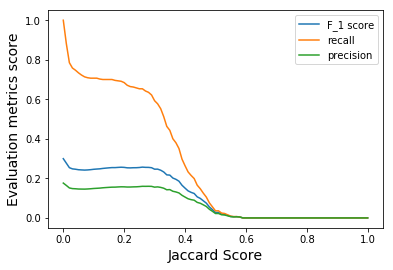

In [97]:
plt.plot(ts, fs, label='F_1 score')
plt.plot(ts, rs, label='recall')
plt.plot(ts, ps, label='precision')
plt.xlabel('Jaccard Score', fontsize=14)
plt.ylabel('Evaluation metrics score', fontsize=14)
plt.legend()

In [211]:
fs

array([0.29969829, 0.27697715, 0.25416365, 0.24807903, 0.24631268,
       0.24377555, 0.24276588, 0.2419416 , 0.24272588, 0.24410969,
       0.24601012, 0.24726135, 0.24831949, 0.2504    , 0.25191147,
       0.25333873, 0.25457503, 0.25450082, 0.25556472, 0.25643154,
       0.2556391 , 0.25348542, 0.25308905, 0.25385935, 0.25399568,
       0.25502183, 0.25692917, 0.25579323, 0.25562556, 0.25399726,
       0.24651163, 0.24677188, 0.24132877, 0.23236936, 0.21778012,
       0.21651176, 0.20169014, 0.19529006, 0.18579882, 0.16521739,
       0.15070243, 0.13675214, 0.12920592, 0.12361111, 0.10655148,
       0.0987285 , 0.08662026, 0.07460317, 0.0555102 , 0.04187605,
       0.02749141, 0.02753873, 0.01926445, 0.01771479, 0.01269266,
       0.00743494, 0.00585366, 0.00628931, 0.00451977, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [212]:
index_start = 2
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (train): ", fs[best_f1_index])
print("best threshold (train): ", ts[best_f1_index])

best f1 (train):  0.25692916849978004
best threshold (train):  0.26


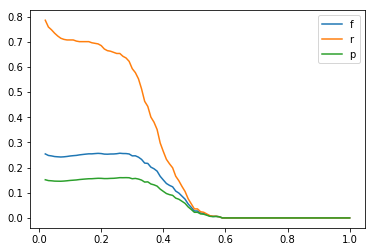

In [213]:
plt.plot(ts[2:], fs[2:], label='f')
plt.plot(ts[2:], rs[2:], label='r')
plt.plot(ts[2:], ps[2:], label='p')
plt.legend()

### Jaccard test

In [20]:
pick_n = 1

In [21]:
test_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'jaccard_score'])
grouped = test_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['jaccard_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'jaccard_score': group_sorted.iloc[i]['jaccard_score']}
        test_res = test_res.append(new_values, ignore_index=True)

In [23]:
# one item
test_res_copy = test_res.copy()

threshold = 0.26
test_res_copy['prediction'] = test_res.jaccard_score > threshold

res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

test_res_copy['eval'] = res_np

p, r, f1 = utils.f1_score(test_res_copy['eval'])

FP = 385
TN = 149
TP = 64
FN = 37
precision = 0.143
recall = 0.634
f1_score = 0.233


In [11]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    test_res_copy = test_res.copy()

    threshold = t
    test_res_copy['prediction'] = test_res.jaccard_score > threshold

    res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

    test_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(test_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

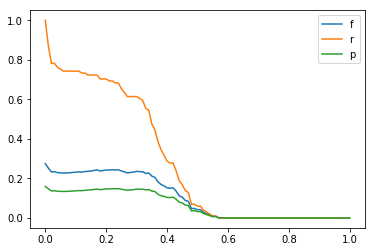

In [12]:
plt.plot(ts, fs, label='f')
plt.plot(ts, rs, label='r')
plt.plot(ts, ps, label='p')
plt.legend()

In [14]:
index_start = 2
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (train): ", fs[best_f1_index])
print("best threshold (train): ", ts[best_f1_index])

best f1 (train):  0.2434782608695652
best threshold (train):  0.22


### Levenstein train

In [124]:
pick_n = 1

In [125]:
train_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'levenstein_score'])
grouped = train_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['levenstein_score'], ascending=True)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'levenstein_score': group_sorted.iloc[i]['levenstein_score']}
        train_res = train_res.append(new_values, ignore_index=True)

In [230]:
# one item
train_res_copy = train_res.copy()

threshold = 0.26
train_res_copy['prediction'] = train_res.levenstein_score > threshold

res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

train_res_copy['eval'] = res_np

p, r, f1 = functions.f1_score(train_res_copy['eval'])

FP = 3623
TN = 179
TP = 349
FN = 899
precision = 0.087865055387714
recall = 0.2796474358974359
f1_score = 0.13371647509578544


In [126]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    train_res_copy = train_res.copy()

    threshold = t
    train_res_copy['prediction'] = train_res.levenstein_score > threshold

    res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

    train_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(train_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

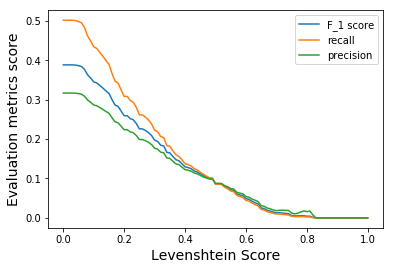

In [127]:
plt.plot(ts, fs, label='F_1 score')
plt.plot(ts, rs, label='recall')
plt.plot(ts, ps, label='precision')
plt.xlabel('Levenshtein Score', fontsize=14)
plt.ylabel('Evaluation metrics score', fontsize=14)
plt.legend()

In [128]:
index_start = 0
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (train): ", fs[best_f1_index])
print("best threshold (train): ", ts[best_f1_index])

best f1 (train):  0.38804071246819344
best threshold (train):  0.0


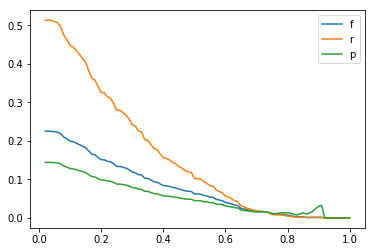

In [236]:
plt.plot(ts[2:], fs[2:], label='f')
plt.plot(ts[2:], rs[2:], label='r')
plt.plot(ts[2:], ps[2:], label='p')
plt.legend()

### Levenstein test

In [24]:
pick_n = 1

In [25]:
test_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'levenstein_score'])
grouped = test_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['levenstein_score'], ascending=True)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'levenstein_score': group_sorted.iloc[i]['levenstein_score']}
        test_res = test_res.append(new_values, ignore_index=True)

In [28]:
# one item
test_res_copy = test_res.copy()

threshold = 0.39
test_res_copy['prediction'] = test_res.levenstein_score > threshold

res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

test_res_copy['eval'] = res_np

p, r, f1 = utils.f1_score(test_res_copy['eval'])

FP = 295
TN = 24
TP = 41
FN = 275
precision = 0.122
recall = 0.13
f1_score = 0.126


In [17]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    test_res_copy = test_res.copy()

    threshold = t
    test_res_copy['prediction'] = test_res.levenstein_score > threshold

    res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

    test_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(test_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

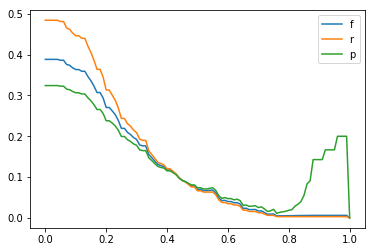

In [20]:
plt.plot(ts, fs, label='f')
plt.plot(ts, rs, label='r')
plt.plot(ts, ps, label='p')
plt.legend()

In [21]:
index_start = 0
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (train): ", fs[best_f1_index])
print("best threshold (train): ", ts[best_f1_index])

best f1 (train):  0.3883248730964467
best threshold (train):  0.0


### Concurrent train

In [103]:
pick_n = 1

In [104]:
train_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'concur_score'])
grouped = train_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['concur_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'concur_score': group_sorted.iloc[i]['concur_score']}
        train_res = train_res.append(new_values, ignore_index=True)

In [248]:
# one item
train_res_copy = train_res.copy()

threshold = 0.26
train_res_copy['prediction'] = train_res.concur_score > threshold

res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

train_res_copy['eval'] = res_np

p, r, f1 = functions.f1_score(train_res_copy['eval'])

FP = 129
TN = 4843
TP = 4
FN = 74
precision = 0.03007518796992481
recall = 0.05128205128205128
f1_score = 0.037914691943127965


In [105]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    train_res_copy = train_res.copy()

    threshold = t
    train_res_copy['prediction'] = train_res.concur_score > threshold

    res_np = np.zeros(train_res_copy.shape[0]).astype(np.str)
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction)] = 'TP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction)] = 'FP'
    res_np[(train_res_copy.true_label == False) & (train_res_copy.prediction == False)] ='TN'
    res_np[(train_res_copy.true_label) & (train_res_copy.prediction == False)] = 'FN'

    train_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(train_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

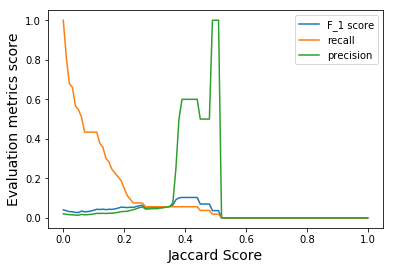

In [106]:
plt.plot(ts, fs, label='F_1 score')
plt.plot(ts, rs, label='recall')
plt.plot(ts, ps, label='precision')
plt.xlabel('Jaccard Score', fontsize=14)
plt.ylabel('Evaluation metrics score', fontsize=14)
plt.legend()

In [107]:
fs

array([0.04095827, 0.03639441, 0.03157895, 0.03116652, 0.02756086,
       0.02724284, 0.03459321, 0.03058511, 0.03214535, 0.03437967,
       0.03885135, 0.0436019 , 0.04259851, 0.04398148, 0.04188482,
       0.04360465, 0.04304636, 0.04571429, 0.04954955, 0.05449591,
       0.05369128, 0.05217391, 0.05405405, 0.05333333, 0.05755396,
       0.06153846, 0.064     , 0.05      , 0.05042017, 0.05128205,
       0.05128205, 0.05128205, 0.05309735, 0.05405405, 0.05607477,
       0.05714286, 0.06521739, 0.09230769, 0.10169492, 0.10344828,
       0.10344828, 0.10344828, 0.10344828, 0.10344828, 0.10344828,
       0.07017544, 0.07017544, 0.07017544, 0.07017544, 0.03703704,
       0.03703704, 0.03703704, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [108]:
index_start = 0
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (train): ", fs[best_f1_index])
print("best threshold (train): ", ts[best_f1_index])

best f1 (train):  0.10344827586206896
best threshold (train):  0.39


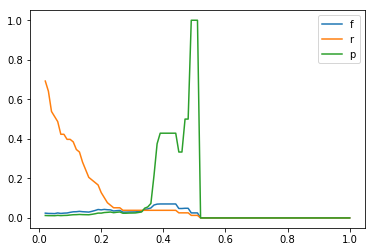

In [253]:
plt.plot(ts[2:], fs[2:], label='f')
plt.plot(ts[2:], rs[2:], label='r')
plt.plot(ts[2:], ps[2:], label='p')
plt.legend()

### Concurrent test

In [29]:
pick_n = 1

In [30]:
test_res = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 'true_label', 'concur_score'])
grouped = test_pairs.groupby('red_link_name')
for name, group in grouped:
    group_sorted = group.sort_values(by=['concur_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                          'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                          'candidate': group_sorted.iloc[i]['candidate'], 
                          'true_label': group_sorted.iloc[i]['true_label'], 
                          'concur_score': group_sorted.iloc[i]['concur_score']}
        test_res = test_res.append(new_values, ignore_index=True)

In [32]:
# one item
test_res_copy = test_res.copy()

threshold = 0.10
test_res_copy['prediction'] = test_res.concur_score > threshold

res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

test_res_copy['eval'] = res_np

p, r, f1 = utils.f1_score(test_res_copy['eval'])

FP = 263
TN = 360
TP = 2
FN = 10
precision = 0.008
recall = 0.167
f1_score = 0.014


In [121]:
n = 101
ts = np.linspace(0, 1, n) # thresholds
ps = np.zeros(n)
rs = np.zeros(n)
fs = np.zeros(n)
for (i,t) in enumerate(ts):
    
    test_res_copy = test_res.copy()

    threshold = t
    test_res_copy['prediction'] = test_res.concur_score > threshold

    res_np = np.zeros(test_res_copy.shape[0]).astype(np.str)
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction)] = 'TP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction)] = 'FP'
    res_np[(test_res_copy.true_label == False) & (test_res_copy.prediction == False)] ='TN'
    res_np[(test_res_copy.true_label) & (test_res_copy.prediction == False)] = 'FN'

    test_res_copy['eval'] = res_np

    p, r, f = functions.f1_score(test_res_copy['eval'], with_print=False)
    
    ps[i] = p
    rs[i] = r
    fs[i] = f

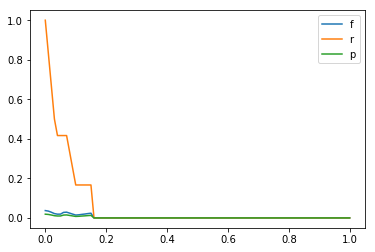

In [122]:
plt.plot(ts, fs, label='f')
plt.plot(ts, rs, label='r')
plt.plot(ts, ps, label='p')
plt.legend()

In [123]:
index_start = 0
best_f1_index = np.argmax(fs[index_start:]) + index_start
print("best f1 (test): ", fs[best_f1_index])
print("best threshold (test): ", ts[best_f1_index])

best f1 (test):  0.03709428129829984
best threshold (test):  0.0


## Run Logistic regression

### LR on Train

In [33]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [34]:
pick_n = 1

In [35]:
grouped = train_pairs.groupby('red_link_name')

train_res_jac = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['jaccard_score'], ascending=False)
    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        train_res_jac = train_res_jac.append(new_values, ignore_index=True)
        
train_res_lev = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['levenstein_score'], ascending=True)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        train_res_lev = train_res_lev.append(new_values, ignore_index=True)   
        
train_res_conc = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['concur_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        train_res_conc = train_res_conc.append(new_values, ignore_index=True)      

In [36]:
train_res_all = train_res_jac.copy()
train_res_all = train_res_all.append(train_res_lev)
train_res_all = train_res_all.append(train_res_conc)

In [37]:
train_res_all.head()

,ground truth,red_link_name,candidate,true_label,jaccard_score,levenstein_score,concur_score,BN_results
0,Constellation,(сузір'я),Angular distance,False,0.317,0.812,0.00450,0
1,1753 in science,1753 у науці,Sarracenia purpurea,False,0.619,0.842,0.05066,0
2,NaN,"200 метрів, комплексне плавання",World record progression 200 metres individual...,False,0.270,0.830,0.02746,0
3,NaN,"400 метрів, комплексне плавання",World record progression 400 metres individual...,False,0.452,0.830,0.02698,0
4,480i,480i,AMC-18,False,0.390,1.000,0.02073,0


In [38]:
train_res_all.shape

(7608, 8)

In [39]:
X_train = train_res_all[['BN_results', 'jaccard_score', 'levenstein_score', 'concur_score']].values
y_train = train_res_all['true_label'].values.astype(np.bool)

In [40]:
# X_test = test_set[['BN_results', 'jaccard_score', 'levenstein_score', 'concur_score']]
# X_test = X_test.values
#y_test = test_set['true_label']

In [41]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/andrii/apps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
# make predictions
y_pred_train = logreg.predict(X_train)

In [43]:
metrics.f1_score(y_train, y_pred_train)

0.8208530805687203

In [44]:
print(metrics.classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       False       0.93      0.97      0.95      5891
        True       0.90      0.76      0.82      1717

   micro avg       0.93      0.93      0.93      7608
   macro avg       0.91      0.87      0.89      7608
weighted avg       0.92      0.93      0.92      7608



In [45]:
def calculate_acc(ground_truth, predictions):

    tp = np.sum((ground_truth.astype(np.int) + predictions.astype(np.int)) == 2)
    tn = np.sum((ground_truth.astype(np.int) + predictions.astype(np.int)) == 0)
    fn = np.sum((ground_truth.astype(np.int) - predictions.astype(np.int)) == 1)
    fp = np.sum((ground_truth.astype(np.int) - predictions.astype(np.int)) == -1)

    r = tp/(tp+fn)
    p = tp/(tp+fp)
    f1 = 2*r*p/(r+p)
    
    return r, p, f1

In [46]:
calculate_acc(y_train, y_pred_train)

(0.7565521258008153, 0.8970994475138122, 0.8208530805687203)

In [47]:
print(logreg.coef_)
print(logreg.intercept_)

[[ 2.18925364 -0.62120606 -8.00908379  1.65408456]]
[3.57781192]


### LR on Test

In [48]:
pick_n = 1

In [49]:
grouped = test_pairs.groupby('red_link_name')

test_res_jac = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['jaccard_score'], ascending=False)
    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        test_res_jac = test_res_jac.append(new_values, ignore_index=True)
        
test_res_lev = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['levenstein_score'], ascending=True)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        test_res_lev = test_res_lev.append(new_values, ignore_index=True)   
        
test_res_conc = pd.DataFrame(columns=['ground truth', 'red_link_name', 'candidate', 
                                      'true_label', 'jaccard_score', 'levenstein_score', 
                                      'concur_score', 'BN_results'])
for name, group in grouped:
    group_sorted = group.sort_values(by=['concur_score'], ascending=False)

    for i in range(min(group_sorted.shape[0], pick_n)):
        new_values = {'ground truth': group_sorted.iloc[i]['ground truth'], 
                      'red_link_name': group_sorted.iloc[i]['red_link_name'], 
                      'candidate': group_sorted.iloc[i]['candidate'], 
                      'true_label': group_sorted.iloc[i]['true_label'], 
                      'jaccard_score': group_sorted.iloc[i]['jaccard_score'],
                      'levenstein_score': group_sorted.iloc[i]['levenstein_score'],
                      'concur_score': group_sorted.iloc[i]['concur_score'],
                      'BN_results': group_sorted.iloc[i]['BN_results']
                     }
        test_res_conc = test_res_conc.append(new_values, ignore_index=True)    

In [50]:
test_res_all = test_res_jac.copy()
test_res_all = test_res_all.append(test_res_lev)
test_res_all = test_res_all.append(test_res_conc)

In [51]:
test_res_all.head()

,ground truth,red_link_name,candidate,true_label,jaccard_score,levenstein_score,concur_score,BN_results
0,2 Chainz,2 Chainz,Fatboi,False,0.439,0.875,0.03140,0
1,ASL Airlines Belgium,ASL Airlines Belgium,Maastricht Aachen Airport,False,0.611,0.880,0.07475,0
2,Abraxas grossulariata,Abraxas grossulariata,Eulamprotes unicolorella,False,0.619,0.792,0.02986,0
3,Abrostola asclepiadis,Abrostola asclepiadis,Gnophos obfuscata,False,0.622,0.810,0.02985,0
4,Aglossa pinguinalis,Aglossa pinguinalis,Silver-washed fritillary,False,0.595,0.833,0.02381,0


In [52]:
test_res_all.shape

(1905, 8)

In [53]:
X_test = test_res_all[['BN_results', 'jaccard_score', 'levenstein_score', 'concur_score']].values
y_test = test_res_all['true_label'].values.astype(np.bool)

In [54]:
# X_test = test_set[['BN_results', 'jaccard_score', 'levenstein_score', 'concur_score']]
# X_test = X_test.values
#y_test = test_set['true_label']

In [55]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/home/andrii/apps/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [56]:
# make predictions
y_pred_test = logreg.predict(X_test)

In [57]:
metrics.f1_score(y_test, y_pred_test)

0.8485607008760951

In [58]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

       False       0.94      0.98      0.96      1476
        True       0.92      0.79      0.85       429

   micro avg       0.94      0.94      0.94      1905
   macro avg       0.93      0.88      0.90      1905
weighted avg       0.94      0.94      0.93      1905



In [61]:
def calculate_acc(ground_truth, predictions):

    tp = np.sum((ground_truth.astype(np.int) + predictions.astype(np.int)) == 2)
    tn = np.sum((ground_truth.astype(np.int) + predictions.astype(np.int)) == 0)
    fn = np.sum((ground_truth.astype(np.int) - predictions.astype(np.int)) == 1)
    fp = np.sum((ground_truth.astype(np.int) - predictions.astype(np.int)) == -1)

    r = tp/(tp+fn)
    p = tp/(tp+fp)
    f1 = 2*r*p/(r+p)
    
    print('FP:', fp)
    print('TN:', tn)
    print('TP:', tp)
    print('fn:', fn)
    print('precision:', p)
    print('recall:', r)
    print('f1_score:', f1)
    
    return r, p, f1

In [62]:
calculate_acc(y_test, y_pred_test)

FP: 31
TN: 1445
TP: 339
fn: 90
precision: 0.9162162162162162
recall: 0.7902097902097902
f1_score: 0.8485607008760951


(0.7902097902097902, 0.9162162162162162, 0.8485607008760951)

In [69]:
print(logreg.coef_)
print(logreg.intercept_)

[[ 2.18925364 -0.62120606 -8.00908379  1.65408456]]
[3.57781192]
